# Exploration of the binomial model for directionality

Based on the relative orientations of the reads of a read pair, we classify read pairs as either *simple* or *twisted*. For Hi-C and capture Hi-C data, there are roughly the same number of simple and twisted read pairs, after artifact read pairs (un-ligated, self-ligated, etc.) have been filtered out. On the other hand, there can be extreme imbalances of simple and twisted read pairs within individual interactions. We use a binomial test with $p=0.5$ to assess imbalances within individual interactions for statistical significance. For example, if an interaction has $s=5$ simple and $t=10$ twisted read pairs, then we use

$$B(k=s, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

with a certain P-value threshold to decide whether the interaction is directed or not. Conversely, if an interaction has $s=10$ simple und $t=5$ twisted read pairs, we use:

$$B(k=t, n=s+t, p=0.5)=B(k=5, n=15, p=0.5)$$

This is basically a two-sided binomial test. When setting the P-value threshold, it is important to note that the test is two-sided. For example, if you want $\alpha$ to be $0.05$, then the threshold must be set to $0.025$. It is also important to be aware that we are only testing the imbalances of simple and twisted read pairs within individual interactions. The total number of read pairs ($n$) is not taken into account. Because $n$ is a parameter of the binomial distribution, we therefore use different null models for the evaluation of interactions with different $n$. An obvious consequence is that the power of the test increases with $n$.

In this Jupyter Notebook, we review our implmentation of the test and investigate how it behaves as a function of $n$. We also carry out a more theoretical analysis that is independent of our implementation of the P-value calculation. The aim of this analysis is to better understand previously observed periodic fluctuations in the numbers of significant interactions for different $n$. Finally, we determine the distributions of $n$ for significant and non-significant interactions from real data in order to see how our test affects the distribution of $n$ in the significant interactions.

## Setting up the notebook

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import scipy, scipy.stats, numpy

%matplotlib inline

# Import BinomialInteractionModel
sys.path.append("..")
from diachr import BinomialInteractionModel

## Verification of the implementation of the P-value calculation through simulation

In this section of the notebook, we simualte interactions and evaluate them with our implementation of the P-value calculation. For this purpose, we simulate interactions with simple and twisted read pairs by drawing the total number of read pairs ($n$) from a uniform ditribution and then choosing randomly a number of simple read pairs ($s<=n$) using the binomial distribution with $p=0.5$ (null model). Then we evaluate the simulated interactions using our implementation of the P-value calculation and determine the number of significant interactions at a specified P-value threshold for each $n$.

First we create an object of class `BinomialInteractionModel`. Initially, the P-value threshold at which interactions are classified as directed is set and the minimum number of read pairs required for significance is determined. For example, if the threshold is $0.05$, then at least 5 read pairs are required for significance, because the P-value for the most extreme cases (zero simple or zero twisted read pairs) with $n=4$ read pairs are already greater than the threshold ($0.0625$). We do not simulate interactions that have too few read pairs to be significant.

In [2]:
p_value_cutoff=0.05
bim = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.05.
	[INFO] Smallest n: 5 read pairs (0.03125)
[INFO] Parameters
	[INFO] _out_prefix: OUT_PREFIX
	[INFO] _p_value_cutoff: 0.05
	[INFO] _n_indef: 5
	[INFO] _pv_indef: 0.03125


Next we simulate and evaluate interactions. To do this, we need to set two parameters:

1. The maximum number of read pairs per interaction (`n_max`)
2. The number of interactions to be simulated (`i_num`)

We use the numpy function `randint` in order draw `i_num` total read pair numbers from a uniform distribution:

`np.random.randint(low = self._n_indef, high = n_max  + 1, size = i_num)`

Note that we only draw numbers that are greater or equal to the previously determined number of read pairs that are required for significance (`low = self._n_indef`). For the sake of efficiency, we draw all random numbers at once.

Then we determine for each $n$=`_n_indef`, ..., `n_max` how often it was drawn (`i`) and draw a corresponding number of simple read pair counts from the binomial distribution:

`simple_count_list = list(binom.rvs(n, p = 0.5, size = i))`

For each simple count, we determine a P-value using our implementation of the P-value calculation. If the P-value is below the half of the chosen threshold (the test is two-sided), we increment the number of significant interactions for the current $n$ by 1.

The function below implements the simualtion and returns three lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_sim_list`: List with numbers of simulated interactions for each $n$
3. `n_sig_list`: List with numbers of significant simulated interactions for each $n$

Note that all three lists are `n_max+1` in length and the index corresponds to n.

Run the cell below to perform the simulation.

In [22]:
n_max=400
i_num=20000000
n_list_s, n_sim_list, n_sig_list = bim.simulate_interactions(n_max=n_max, i_num=i_num)

[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


Note that we are simulating a very large number of interactions. The reason for this is that we simulate the interactions according to our null model. Using a P-value threshold of $0.05$, we expect only 5% of the simulated interactions to be significant (actually the false positives). These 5% are distributed over $n=1,...,$ `n_max`, i.e. we expect only `p_value_cutoff*(i_num/n_max)` significant interactions for each $n$. To get a clear picture, we need as many significant interactions as possible.

Run the cell below to create a combined plot with the total numbers of simulated interactions and simulated significant interactions for each $n$.

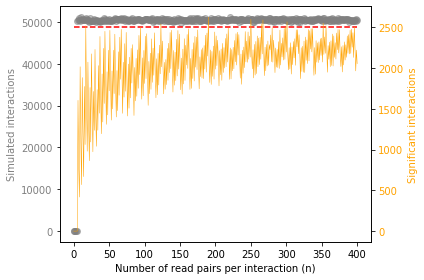

In [40]:
fig, ax1 = plt.subplots()
#plt.xlim(0,200)
color = 'gray'
ax1.set_xlabel('Number of read pairs per interaction (n)')
ax1.set_ylabel('Simulated interactions', color=color)
ax1.scatter(n_list_s, n_sim_list, color=color, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = (255/255,163/255,0/255,1)
ax2.set_ylabel('Significant interactions', color=color)
ax2.plot(n_list_s, n_sig_list, color=color, linewidth=0.5)
#ax2.scatter(n_list_s, n_sig_list, color=color, alpha=0.5)
ax2.hlines(bim._p_value_cutoff*(i_num/n_max),0, n_max, color='red', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

The x-axis shows the number of read pairs per interaction ($n$). The left y-axis shows the total number of simulated interactions (gray). The right y-axis shows the number of significant interactions (orange). The red dahsed line relates to the right y-axis and is drawn at the level for the expected number of significant interaction for each $n$.

It can be seen that the simulated interactions (gray) are evenly distributed across the different $n$. It can also be seen that no interactions are simulated for very small $n$. These are those interactions that cannot be significant at the given P-value threshold. The number of significant interactions fluctuates strongly (orange). For smaller $n<150$, the fluctuations are greater and there are often less significant interactions. After that, the curve remains just below the expected number of significant interactions (red dashed line). Especially for larger $n$, a periodicity can be seen.

Now we repeat the simulation for a smaller P-value threshold. We simulate five times as many interactions as before in order to get sufficiently significant interactions despite the small P-value threshold.

In [46]:
p_value_cutoff=0.0019
bim_2 = BinomialInteractionModel(p_value_cutoff=p_value_cutoff)
n_max=400
i_num=100000000
n_list, n_sim_list, n_sig_list = bim_2.simulate_interactions(n_max=n_max, i_num=i_num)

[INFO] Looking for smallest number of read pairs n that yields a significant P-value with the threshold of 0.0019.
	[INFO] Smallest n: 10 read pairs (0.0009765625)
[INFO] Parameters
	[INFO] _out_prefix: OUT_PREFIX
	[INFO] _p_value_cutoff: 0.0019
	[INFO] _n_indef: 10
	[INFO] _pv_indef: 0.0009765625
[INFO] Generating random numbers of simple and twisted read pairs ...
[INFO] Counting significant interactions for each n ...


Run the cell below to create a combined plot with the total numbers of simulated interactions and simulated significant interactions for each $n$.

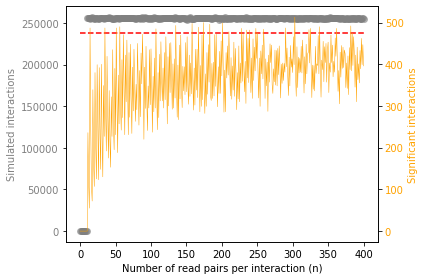

In [52]:
fig, ax1 = plt.subplots()
#plt.xlim(0,200)
color = 'gray'
ax1.set_xlabel('Number of read pairs per interaction (n)')
ax1.set_ylabel('Simulated interactions', color=color)
ax1.scatter(n_list, n_sim_list, color=color, alpha=0.5)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = (255/255,163/255,0/255,1)
ax2.set_ylabel('Significant interactions', color=color)
ax2.plot(n_list, n_sig_list, color=color, linewidth=0.5)
#ax2.scatter(n_list_s, n_sig_list, color=color, alpha=0.5)
ax2.hlines(bim_2._p_value_cutoff*(i_num/n_max),0, n_max, color='red', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

Because we used a much smaller P-value threshold, we also have less significant interactions. However, the picture is similar to the first simulation. Interactions with fewer read pairs are less often significant as interactions with many read pairs. There are fluctuations that decrease with increasing $n$, but do not look as regular as in the first simulation. We attribute the lower regularity of the fluctuations to the smaller number of significant interactions that result from the smaller P-value threshold.

If we simulate a lot more interactions (takes a long time), the fluctuations look more regular again.

We attribute the periodic fluctuations to the discrete nature of the binomial distribution. We find that our test for directionality of interactions is not independent of $n$, especially for small $n$.

One consequence that drew from this simulation study was that we do not simply compare directed interactions with all undirected interactions, but rather with *undirected reference interactions*, which we select in such a way that they are comparable to directed interactions in terms of the distribution of $n$. The idea is that, in this way, both sets of interactions will be similarly affected by the irregularities we found.

## Binomial distributions for different n and a fixed P-value threshold

In this section of the notebook, we try to better understand the observed periodic fluctuations in the significant interactions for different $n$.

For given interactions, we test the ratio of simple and twisted read pairs for statistical significance using a binomial test. When we do this, we use the same P-value threshold for all interactions, but interactions have different total numbers of read pairs ($n$). For different $n$, the test is based on different *discrete distributions*. On the other hand, the P-value refers to the sum of the probability densities, which can only be values between $0$ and $1$.

Let $d_k$ be the denstity for some $k\in \{1,...,n\}$. For every $n$, the P-value threshold corresponds to a certain $k_{max}$, so that the sum $\sum_{k=0}^{k_{max}}d_k$ is as large as possible and at the same time smaller than the threshold value. If we go from $n$ to $n+1$, then the distribution becomes broader, so that the densities for all possible $k$ become smaller. A distinction must be made between two cases:

1. $\sum_{k=0}^{k_{max}+1}d_k$ *remains greater* than the P-value threshold

2. $\sum_{k=0}^{k_{max}+1}d_k$ *becomes smaller* than the P-value threshold

In the first case, we keep $k_{max}$. Since the interval remains the same and the densities become smaller overall, it becomes less likely to observe a significant $k<=k_{max}$ under the model with $n+1$. In the second case, the sum $\sum_{k=0}^{k_{max}}d_k$ becomes smaller too because the distribution becomes broader overall, but the density for $d_{k_{max}+1}$ is added to this sum. Overall, this makes it more likely to observe a significant $k<=(k_{max}+1)$ under the model with $n+1$.

For illustration purposes, we generate binomial distributions for $n=1, ..., N$. For each $n$, we determine the largest $k_{max}$ for which $\sum_{k=0}^{k_{max}}d_k$ is smaller than the half of a fixed P-value threshold. In the context of interactions, this $k$ corresponds to the largest number of simple read pairs for which the test is still significant at the given $n$. Conversely, $n-k$ corresponds to the number of twisted read pairs, which is why we are using only the half of the theshold. For each $n$, we keep track of all $k_{max}$ as well as the corresponding $\sum_{k=0}^{k_{max}}d_k$ and show them at the end in a combined plot. Optionally, each individual distribution can be plotted.

The function in cell below takes three arguments:

1. `N` - Binomial distributions for $n=1, ..., N$ will be generated
2. `pvt` - Fixed P-value threshold
3. `CREATE_DIST_PLOTS` - Set this to `True` to plot every single binomial distribution for $n = 1, ..., N$, otherwise only one combined plot will be generated that is explained further below.

Execute the cell to make the function available.

In [49]:
def analyze_N_binomial_distributions_with_fixed_p_thresh(N=40, pvt=0.05, CREATE_DIST_PLOTS=True):

    # Intit lists for the final plot
    n_list = []
    d_sum_prev_list = []
    k_pvt_list = []

    # Create binomial distributions for n = 1, ..., N
    for n in range(1,N+1):

        # Get list of densities for current n
        x = list(scipy.arange(0,n+1,1.0))
        pmf = scipy.stats.binom.pmf(x,n,0.5)

        # Find largest k for which the sum of densities from 0 up to k is below the P-value threshold    
        d_sum = 0.0
        d_sum_prev = 0.0
        k_pvt = 0
        for density in pmf:
            d_sum = d_sum + density
            if pvt/2 < d_sum:
                break
            else:
                k_pvt += 1
                d_sum_prev=d_sum

        # Collect determined values for the final plot
        n_list.append(n)
        d_sum_prev_list.append(d_sum_prev)
        k_pvt_list.append(k_pvt)

        # Create distribution plot for current n
        if CREATE_DIST_PLOTS:
            if d_sum_prev > 0.0:
                color = 'blue'
            else:
                color = 'red'
            plt.title('P_VAL_THRESH=' + str(pvt) + \
                      ', n=' + str(n) + \
                      ', $k_{max}$=' + str(k_pvt) + \
                      ', P-val=' + "{:.4f}".format(d_sum_prev))
            plt.xlabel('n')
            plt.ylabel('Density')
            plt.xlim(-1,N)
            plt.ylim(0,0.5)
            plt.bar(x,pmf,color=color)
            plt.vlines(0,0,N)
            plt.vlines(n,0,N)
            plt.axvspan(0, k_pvt, facecolor='b', alpha=0.2)
            plt.axvspan(n-k_pvt, n, facecolor='b', alpha=0.2)
            plt.show()

    # Calculate trendline    
    spl=scipy.interpolate.UnivariateSpline(n_list,d_sum_prev_list)
    spl.set_smoothing_factor(0.5)
    
    # Create final plot with two y-axes, one for d_sum and one for k_pvt
    fig, ax1 = plt.subplots()
    color = 'cornflowerblue'
    ax1.set_xlabel('n')
    ax1.set_ylabel('P-value', color=color)
    ax1.plot(n_list, d_sum_prev_list, color=color)
    ax1.plot(n_list, spl(n_list), color='blue')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.hlines(pvt/2,0,N, color='red', linestyle='dashed')

    ax2 = ax1.twinx()

    color = 'black'
    ax2.set_ylabel('$k_{max}$', color=color)
    ax2.scatter(n_list, k_pvt_list, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

First we look only at the distributions for $n=1,...,10$ so that the individual transitions from $n$ to $n+1$ can be seen better. Execute the cell below.

With the selected P-value threshold, there are no significant interactions for $n=1,...,5$. This is because even the most extreme outcomes ($k=0$) leads to a P-value that is above the threshold.

For $n=6$, the test can be significant for the first time, where $k_{max}=1$ and the P-value is $0.0156$.

For $n=7$, $k_{max}=1$ remains unchanged and the P-value goes down to $0.0078$. Note that it has become less likely to observe $k=1$ or $k=0$. That's because the distribution has broadened. Case one has occured.

For $n=8$, $k_{max}=1$ remains unchanged and the P-value goes down to $0.0039$. Case one has occured.

For $n=9$, $k_{max}$ increases  to $2$ and the P-value goes up to $0.0195$. Case two has occured.

For $n=10$, $k_{max}=2$ remains unchanged and the P-value goes down to $0.0107$. Case one has occured. 

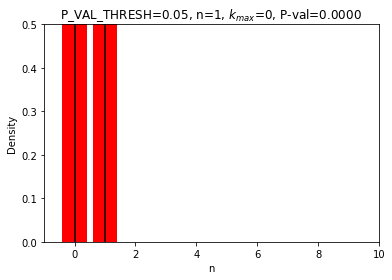

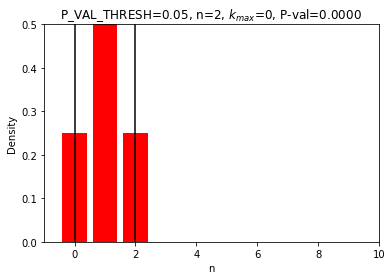

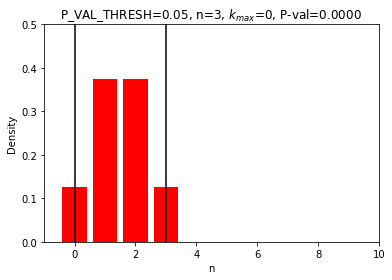

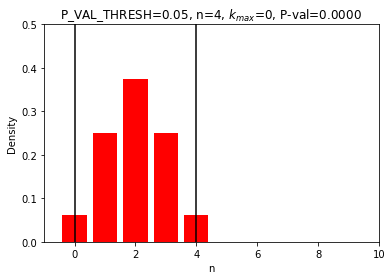

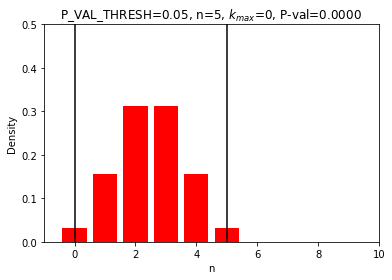

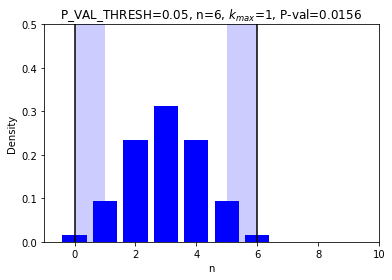

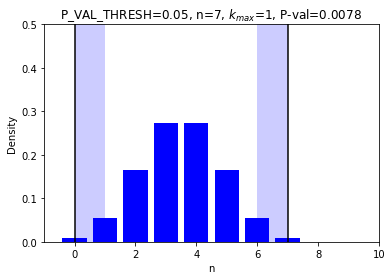

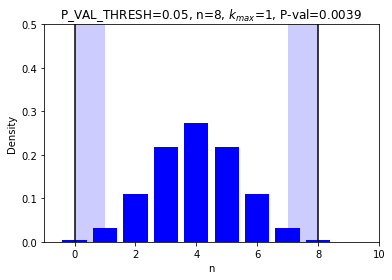

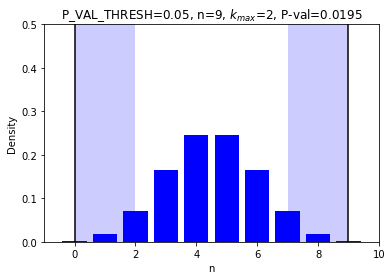

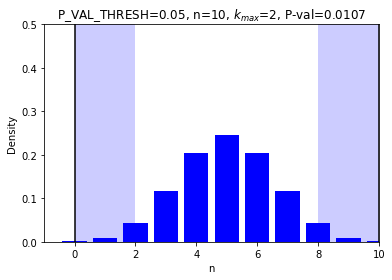

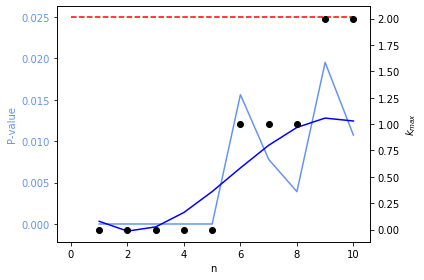

In [50]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=10, pvt=0.05, CREATE_DIST_PLOTS=True)

Next we look at the distributions for $n=1,...,40$. Execute the cell below.

A regular pattern can be seen in which case 1 always occurs two or three times and the case 2 occurs once.

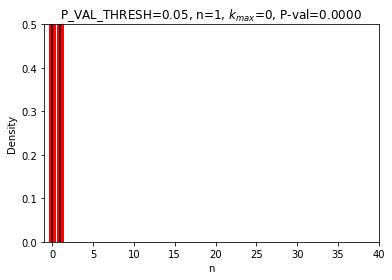

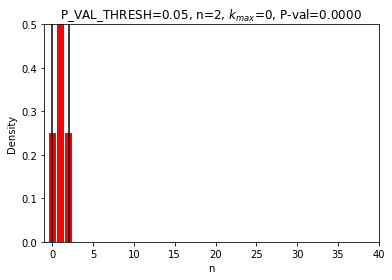

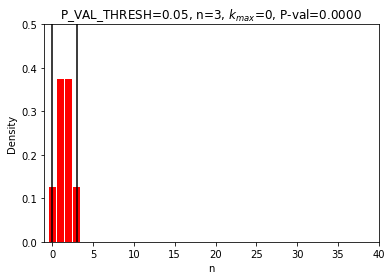

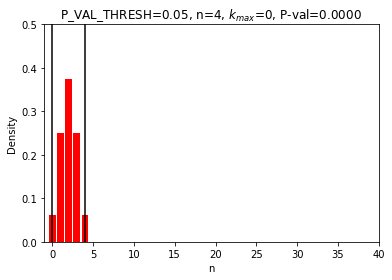

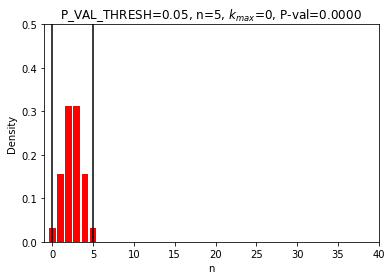

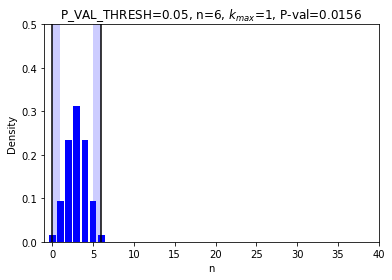

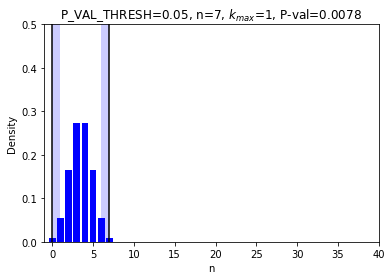

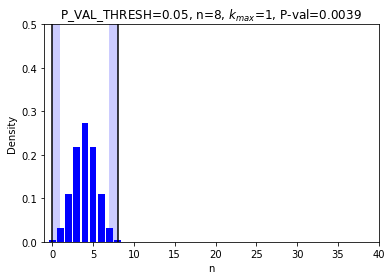

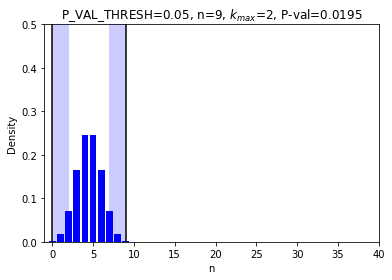

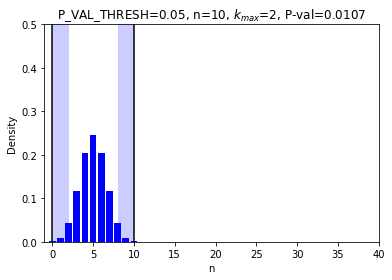

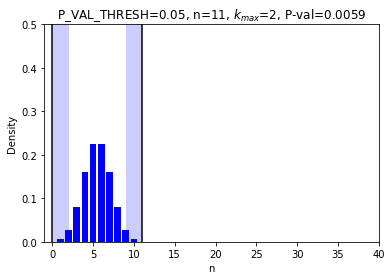

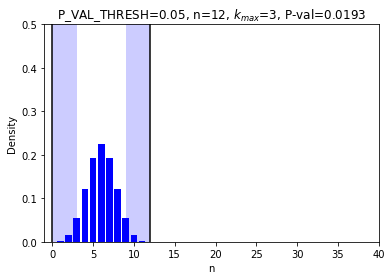

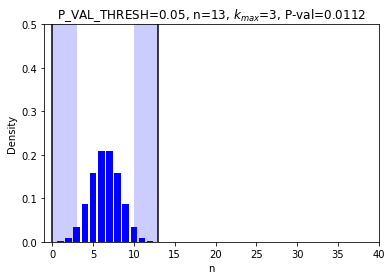

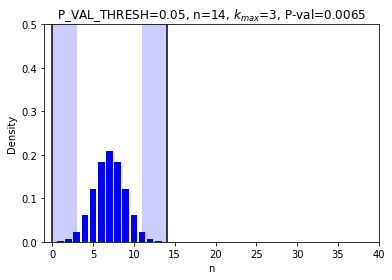

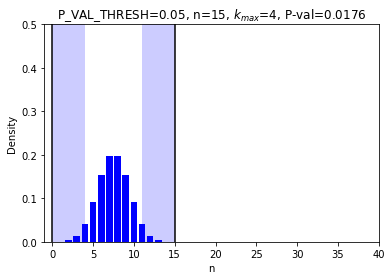

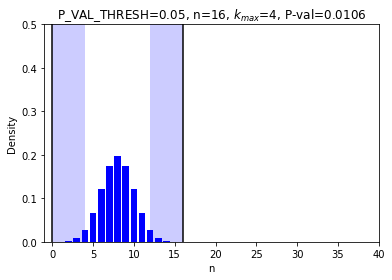

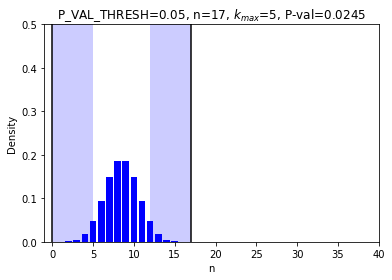

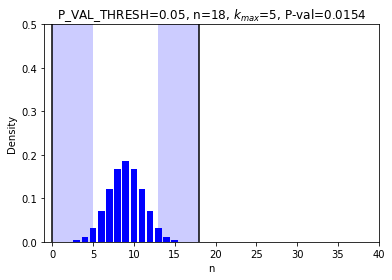

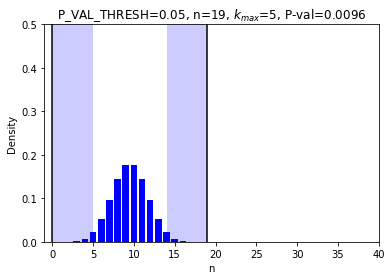

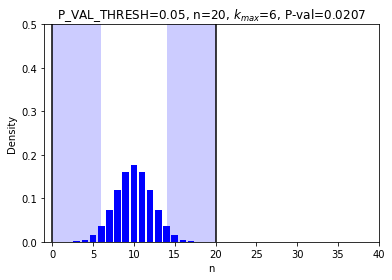

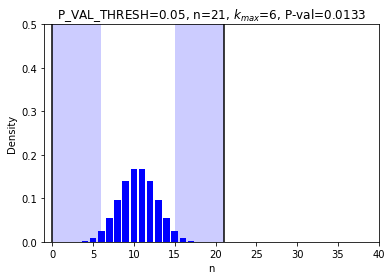

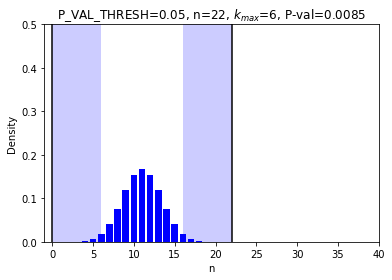

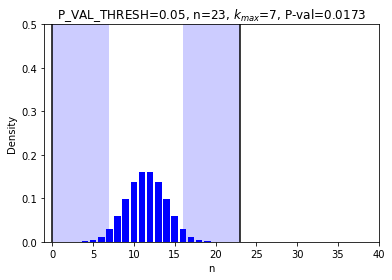

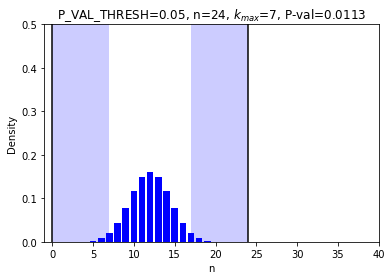

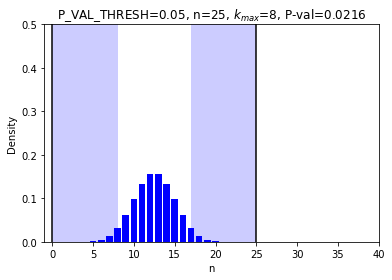

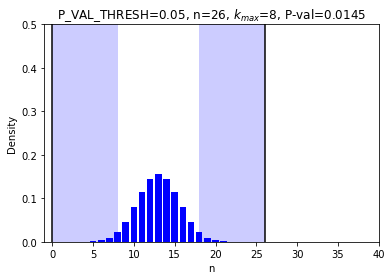

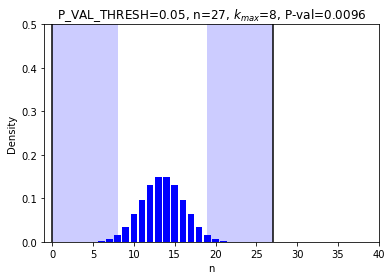

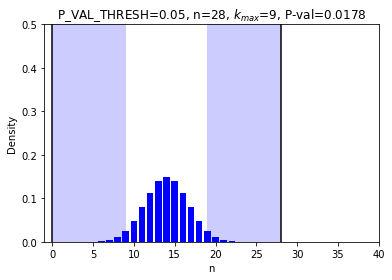

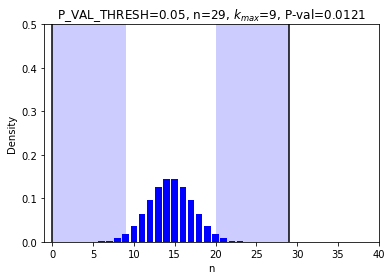

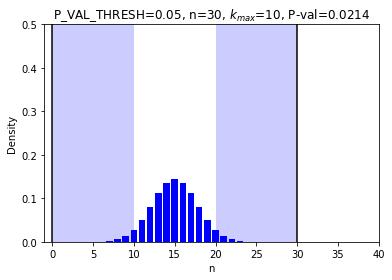

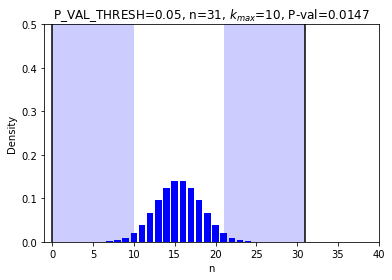

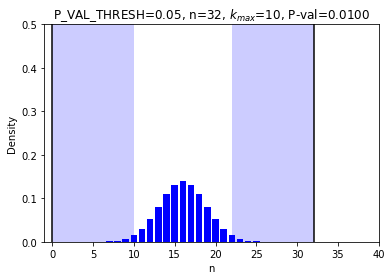

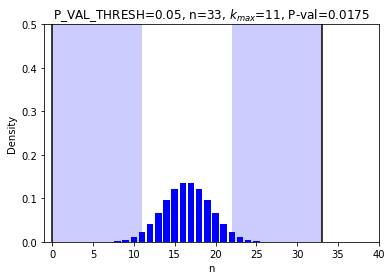

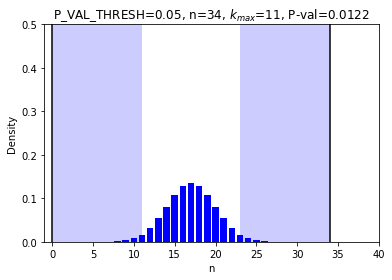

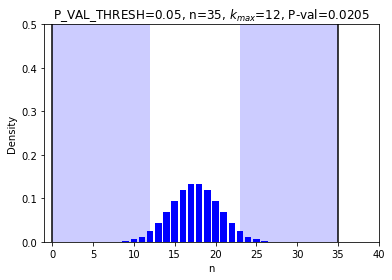

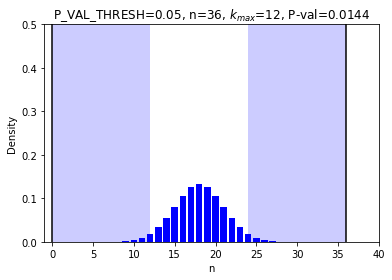

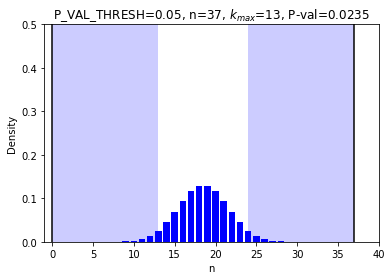

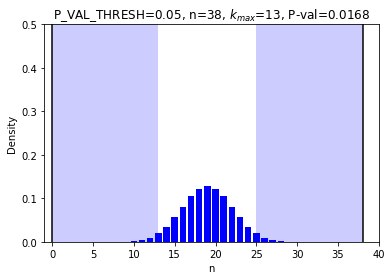

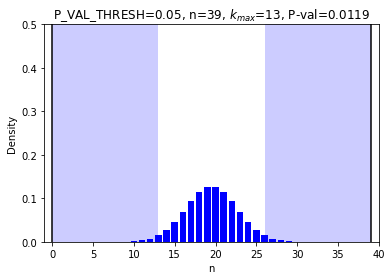

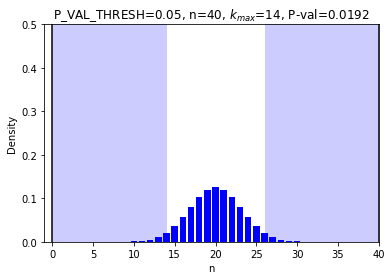

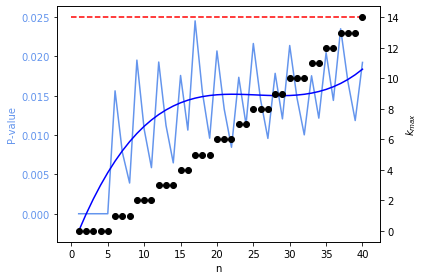

In [51]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=40, pvt=0.05, CREATE_DIST_PLOTS=True)

Now we are using the same parameters that we used for the first simulation of interactions. Execute the cell below.

The curve shape for the P-values is reminiscent of that for simulated significant interactions. The red fitted line for the P-values reaches a plateau at around $n=150$. After that the P-values for the various $n$ are just below the half of the chosen P-value threshold ($0.025$).

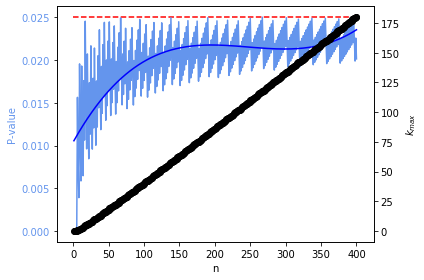

In [24]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=400, pvt=0.05, CREATE_DIST_PLOTS=False)

Now we repeat the analysis with aa smaller P-value threshold of $0.0019$. Execute the cell below.

As with the analysis with a threshold of $0.05$, a plateau is reached at around $n=150$. After that the P-values for the various $n$ are just below the half of the chosen P-value threshold ($0.00095$).

In addition to the periodic fluctuations already observed, other fluctuation with a lower frequency can be seen.

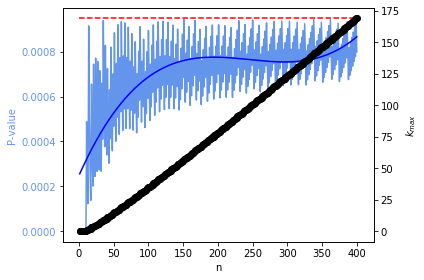

In [19]:
analyze_N_binomial_distributions_with_fixed_p_thresh(N=400, pvt=0.0019, CREATE_DIST_PLOTS=False)

## Distribution of n for empircal data

In this section of the notebook, we examine the distribution of $n$ for a real dataset from a capture Hi-C experiment for megakaryocytes. For this dataset, we defined all interactions with a P-value less than $0.0019$ as directed interactions (**DI**). Then we determined the distribution of $n$ for DI and selected a set of undirected reference interactions with a comparable distribution of $n$ (**UIR**) from all undirected interactions (**UI**).

For this analysis, a file in *Enhanced Interaction Format* is expected as input, with the respective interaction category in the third column.

In [4]:
ie_file = '../results/06_select_reference_interactions/MK/MK_enhanced_interaction_file_with_di_ui_and_uir.tsv.gz'
if not os.path.exists(ie_file):
    raise FileNotFoundError("Could not find IE file")

The function below implements the determination of the empirical distributions of $n$ for DI, UIR and UI and returns four lists:

1. `n_list`: List with consecutive numbers from 0 to `n_max`
2. `n_di_list`: List with numbers of DI for each $n$
3. `n_uir_list`: List with numbers of UIR for each $n$
4. `n_ui_list`: List with numbers of UI for each $n$

In [5]:
n_list, n_di_list, n_uir_list, n_ui_list = bim_2.count_di_uir_and_ui_for_each_n(ei_file=ie_file)

	[INFO] Processed 1000000 interactions ...
	[INFO] Processed 2000000 interactions ...
	[INFO] Processed 3000000 interactions ...
	[INFO] Processed 4000000 interactions ...
	[INFO] Processed 5000000 interactions ...
	[INFO] Processed 1000000 interactions ...
	[INFO] Processed 2000000 interactions ...
	[INFO] Processed 3000000 interactions ...
	[INFO] Processed 4000000 interactions ...
	[INFO] Processed 5000000 interactions ...


Execute the cell below to determine the total number of DI and plot the distribution of $n$.

Total number of DI: 209192


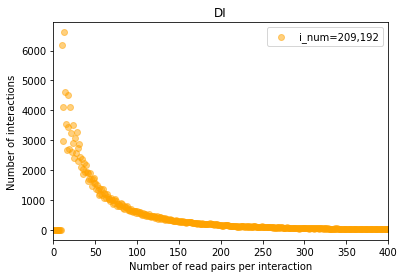

In [6]:
di_sum = 0
for i in n_di_list:
    di_sum += i
print("Total number of DI: " + str(di_sum))
plt.scatter(n_list, n_di_list, alpha=0.5, color=(255/255,163/255,0/255,1),label='i_num=' + str("{:,d}".format(di_sum)))
plt.title('DI')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.xlim(0,400)
plt.legend()
plt.show()

Execute the cell below to determine the total number of UIR and plot the distribution of $n$.

Total number of UIR: 208818


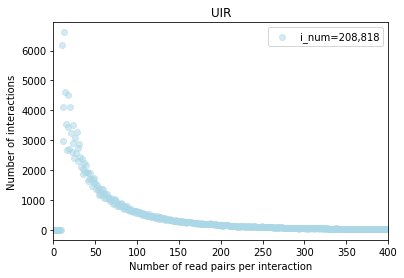

In [8]:
uir_sum = 0
for i in n_uir_list:
    uir_sum += i
print("Total number of UIR: " + str(uir_sum))
plt.scatter(n_list, n_uir_list, alpha=0.5, color=(171/255,215/255,230/255,1),label='i_num=' + str("{:,d}".format(uir_sum)))
plt.title('UIR')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.xlim(0,400)
plt.legend()
plt.show()

It can be seen that DI and UIR have almost the same number of interactions. Furthermore, the distribution of $n$ is almost identical for DI and UIR.

Execute the cell below to determine the total number of UI and plot the distribution of $n$.

Total number of UI: 4831489


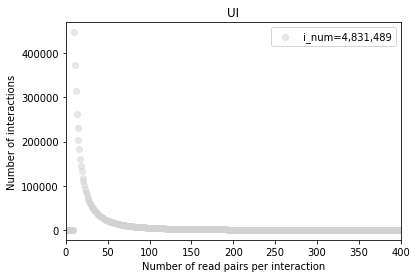

In [9]:
ui_sum = 0
for i in n_ui_list:
    ui_sum += i
print("Total number of UI: " + str(ui_sum))
plt.scatter(n_list, n_ui_list, alpha=0.5, color=(210/255,210/255,210/255,1),label='i_num=' + str("{:,d}".format(ui_sum)))
plt.title('UI')
plt.xlabel('Number of read pairs per interaction')
plt.ylabel('Number of interactions')
plt.xlim(0,400)
plt.legend()
plt.show()

It can be seen that there are many more UI than DI and UIR. It can also be seen that the distribution is shifted towards smaller $n$.

In order to be able to compare the distributions of $n$ for DI, UIR and UI better, we determine the relative frequencies. Execute the cell below.

ValueError: x and y must be the same size

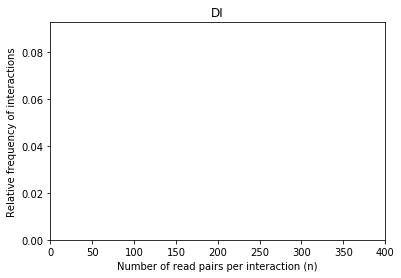

In [23]:
# Get relaative frequencies and common maximum for y-axis
max_rel=0
di_rel = []
for i in n_di_list:
    di_rel.append(i/di_sum)
    if max_rel < i/di_sum:
        max_rel=i/di_sum
uir_rel = []
for i in n_uir_list:
    uir_rel.append(i/uir_sum)
    if max_rel < i/uir_sum:
        max_rel=i/uir_sum
ui_rel = []
for i in n_ui_list:
    ui_rel.append(i/ui_sum)
    if max_rel < i/ui_sum:
        max_rel=i/ui_sum

# Plot distributions of n for DI, UIR and UI with a common y-axis
plt.title('DI')
plt.xlabel('Number of read pairs per interaction (n)')
plt.ylabel('Relative frequency of interactions')
plt.xlim(0,400)
plt.ylim(0,max_rel)
plt.scatter(n_list, di_rel, alpha=0.5, color=(255/255,163/255,0/255,1), label='i_num=' + str("{:,d}".format(di_sum)))
plt.legend()
plt.show()

plt.title('UIR')
plt.xlabel('Number of read pairs per interaction (n)')
plt.ylabel('Relative frequency of interactions')
plt.xlim(0,400)
plt.ylim(0,max_rel)
plt.scatter(n_list, uir_rel, alpha=0.5, color=(171/255,215/255,230/255,1), label='i_num=' + str("{:,d}".format(uir_sum)))
plt.legend()
plt.show()

plt.title('UI')
plt.xlabel('Number of read pairs per interaction (n)')
plt.ylabel('Relative frequency of interactions')
plt.xlim(0,400)
plt.ylim(0,max_rel)
plt.scatter(n_list, ui_rel, alpha=0.5, color=(210/255,210/255,210/255,1), label='i_num=' + str("{:,d}".format(ui_sum)))
plt.legend()
plt.show()

